In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
import torchvision.datasets as datasets

import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset

from tqdm.notebook import tqdm, trange
from sklearn.model_selection import GroupShuffleSplit
import copy
import random
import time

from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil
shutil.unpack_archive(filename ='/content/drive/MyDrive/DS405B/data/Confirmed_fronts.zip', extract_dir = 'confirmed_fronts')

### 1. Split dataset

In [5]:
csv_path='/content/drive/MyDrive/DS405B/data/autosWithNames.csv'
data = pd.read_csv(csv_path)

In [6]:
# Create a unique id for model_id and model_year
data['id']= data['model_id'] + data['model_year'].astype(str)

In [7]:
data.sort_values(by=['id'], inplace=True) # sort the data by model_id and model_year (id)
nb_train = int(len(data) * 0.7)
nb_valid = int(len(data) * 0.1)
nb_test = int(len(data) * 0.2)

Here I see what are the boundary data (those that are going to be split). If they don't have the same model_id, it means that no model will be split accross train - test and valid set

In [8]:
print(data.loc[[nb_train-1]])
print(data.loc[[nb_train]])
print(data.loc[[nb_train+1]])

         brand model_name model_id  model_year bodytype        id
2336  Daihatsu     Terios     24_8        2008      SUV  24_82008
        brand model_name model_id  model_year   bodytype         id
2337  Hyundai       ix20    36_15        2015  Hatchback  36_152015
      brand model_name model_id  model_year   bodytype        id
2338  Dacia    Sandero     22_3        2015  Hatchback  22_32015


In [9]:
print(data.loc[[nb_valid-1]])
print(data.loc[[nb_valid]])
print(data.loc[[nb_valid+1]])

       brand model_name model_id  model_year bodytype         id
332  Hyundai        i40    36_12        2017   Estate  36_122017
      brand model_name model_id  model_year bodytype        id
333  Nissan    Elgrand     64_8        2016      MPV  64_82016
    brand    model_name model_id  model_year     bodytype        id
334  Audi  A5 Cabriolet     7_10        2012  Convertible  7_102012


In [10]:
print(data.loc[[nb_test-1]])
print(data.loc[[nb_test]])
print(data.loc[[nb_test+1]])

    brand     model_name model_id  model_year bodytype        id
666   BMW  M6 Gran Coupe     8_34        2014    Coupe  8_342014
     brand model_name model_id  model_year bodytype         id
667  Volvo        V90    96_14        2017   Estate  96_142017
    brand model_name model_id  model_year   bodytype         id
668   Kia       Soul    43_12        2014  Hatchback  43_122014


In [11]:
# This is false

data=data.sample(frac=1)
train_data = data[:nb_train] # split the datas into train valid and test
test_data = data[:nb_test]
valid_data = data[:nb_valid]

len(train_data), len(test_data), len(valid_data)

(2337, 667, 333)

### 2. Implement data loaders for the training validation and test dataset

In [12]:
class DVMdataset(Dataset):
    def __init__(self, data, img_dir, transforms=True):
    
        df = data
        self.img_dir = img_dir
        self.brand = df['brand'].values
        self.model_year = df['model_year'].values
        self.model = df['model_name'].values
        self.transform = transforms
        
    def __getitem__(self, index):

        dir_path = os.listdir(os.path.join(self.img_dir, self.img_dir, self.brand[index], str(self.model_year[index])))
        brand_name = self.brand[index]
        model_name = self.model[index]
        dico = [brand_name, model_name]
        separator = '$$'
        joindre = separator.join(dico)
        label = []

        for i in range(len(dir_path)):
          joindre2 = ''
          for y in range(len(joindre)):
            joindre2 = joindre2 + dir_path[i][y]
          if joindre2 == joindre:
            lien = os.path.join(self.img_dir, self.img_dir, self.brand[index], str(self.model_year[index]), dir_path[i])
            img = Image.open(os.path.join(self.img_dir, self.img_dir, self.brand[index], str(self.model_year[index]), dir_path[i]))
            if self.transform is not None:
              imga = self.transform(img)
              if 2000 <= self.model_year[index] <= 2003:
                label.append(0)
              elif 2006 <= self.model_year[index] <= 2008:
                label.append(1)
              elif 2009 <= self.model_year[index] <= 2011:
                label.append(2)
              elif 2012 <= self.model_year[index] <= 2014:
                label.append(3)
              elif 2015 <= self.model_year[index] <= 2018:
                label.append(4)
              return imga, label[0]

    def __len__(self):
        return self.brand.shape[0]

In [13]:
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                            transforms.Resize(size=(224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
                                      ])
test_transforms = transforms.Compose([
                           transforms.Resize(size=(224,224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means, std=pretrained_stds),
                                     ])

In [14]:
BATCH_SIZE = 88 # Chosed after wandb runs

train_dataset_1 = DVMdataset(data=train_data,img_dir='confirmed_fronts/',transforms=train_transforms)
train_loader_1 = DataLoader(dataset=train_dataset_1,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True)


valid_dataset_1 = DVMdataset(data=valid_data,img_dir='confirmed_fronts/',transforms=test_transforms)
valid_loader_1 = DataLoader(dataset=valid_dataset_1,
                          batch_size=BATCH_SIZE,
                          shuffle=False)


test_dataset_1 = DVMdataset(data=test_data,img_dir='confirmed_fronts/',transforms=test_transforms)
test_loader_1 = DataLoader(dataset=test_dataset_1,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

### 3. Transfer Learning

In [15]:
import torchvision.models as models

pretrained_model = models.resnet18(pretrained=True) # import resnet18 pretrained model
pretrained_model.fc = nn.Linear(512, 5) # modify the size of the last layer. Here we have only 5 class

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
learning_rate = 0.00067 # chosed after wandb runs

optimizer = optim.Adam(pretrained_model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

model = pretrained_model.to(device)
criterion = criterion.to(device)

In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
%%capture
!pip install wandb --upgrade
import wandb
wandb.login()

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
  'name': 'valid loss',
  'goal': 'minimize'
}

sweep_config['metric'] = metric

parameters_dict = {
    
    'learning_rate': {
        'distribution' : 'uniform',
        'min' : 5e-4,
        'max' : 9e-4,
    },
    'batch_size' : {
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 10,
        'max': 120,
    },
}

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="AS3_TL")

Create sweep with ID: 7v73ey9n
Sweep URL: https://wandb.ai/ojlt/AS3_TL/sweeps/7v73ey9n


In [ ]:
def wandb_train(config=None):
  with wandb.init(config=config):
    config=wandb.config
    pretrained_means = [0.485, 0.456, 0.406]
    pretrained_stds = [0.229, 0.224, 0.225]

    BATCH_SIZE = config.batch_size
    custom_train_transform = transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor(),transforms.Normalize(mean=pretrained_means, std=pretrained_stds)])
    custom_test_transform = transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor(), transforms.Normalize(mean=pretrained_means, std=pretrained_stds)])

    train_dataset_1 = DVMdataset(data=train_data,img_dir='confirmed_fronts/',transforms=train_transforms)
    train_loader_1 = DataLoader(dataset=train_dataset_1,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
    valid_dataset_1 = DVMdataset(data=valid_data,img_dir='confirmed_fronts/',transforms=test_transforms)
    valid_loader_1 = DataLoader(dataset=valid_dataset_1,batch_size=BATCH_SIZE,shuffle=False)
    test_dataset_1 = DVMdataset(data=test_data,img_dir='confirmed_fronts/',transforms=test_transforms)
    test_loader_1 = DataLoader(dataset=test_dataset_1,batch_size=BATCH_SIZE,shuffle=False)
      
    pretrained_model = models.resnet18(pretrained=True)
    pretrained_model.fc = nn.Linear(512, 5)
    learning_rate = config.learning_rate
    optimizer = optim.Adam(pretrained_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    model = pretrained_model.to(device)
    criterion = criterion.to(device)

    EPOCHS = 3
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader_1, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_loader_1, criterion, device)


        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)      
        
        wandb.log({"accuracy valid": valid_acc, "valid loss": valid_loss, "train accuracy": train_acc, "train loss": train_loss, "epoch": epoch}) 

In [ ]:
start_time = time.time()
wandb.agent("5pxurnny", wandb_train, count=10)
elapsed = (time.time() - start_time)/60
print(f'Total Time: {elapsed:.2f} min')

wandb: Agent Starting Run: lps1ywk5 with config:
wandb: 	batch_size: 56
wandb: 	learning_rate: 0.0008660187055024841


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

accuracy valid,▂█▁
epoch,▁▅█
train accuracy,▁▅█
train loss,█▃▁
valid loss,▄▁█
accuracy valid,0.47529
epoch,2
train accuracy,0.61977
train loss,0.87744
valid loss,1.2892


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8er1coz1 with config:
wandb: 	batch_size: 96
wandb: 	learning_rate: 0.0007652298168090528


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

accuracy valid,▁▄█
epoch,▁▅█
train accuracy,▁▄█
train loss,█▄▁
valid loss,█▃▁
accuracy valid,0.78299
epoch,2
train accuracy,0.69618
train loss,0.6992
valid loss,0.57304


wandb: Agent Starting Run: 494olzwq with config:
wandb: 	batch_size: 48
wandb: 	learning_rate: 0.0008497431927066591


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

accuracy valid,▁▆█
epoch,▁▅█
train accuracy,▁▅█
train loss,█▄▁
valid loss,█▃▁
accuracy valid,0.61091
epoch,2
train accuracy,0.61155
train loss,0.8805
valid loss,0.90273


wandb: Agent Starting Run: q8m0lk0g with config:
wandb: 	batch_size: 56
wandb: 	learning_rate: 0.000633679855434118


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

accuracy valid,▁▃█
epoch,▁▅█
train accuracy,▁▅█
train loss,█▃▁
valid loss,█▄▁
accuracy valid,0.71159
epoch,2
train accuracy,0.69294
train loss,0.73087
valid loss,0.71843


wandb: Agent Starting Run: 9qylytdu with config:
wandb: 	batch_size: 48
wandb: 	learning_rate: 0.0007202728067272387


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

accuracy valid,▁█▇
epoch,▁▅█
train accuracy,▁▅█
train loss,█▄▁
valid loss,█▁▄
accuracy valid,0.61964
epoch,2
train accuracy,0.65148
train loss,0.83811
valid loss,1.04432


wandb: Agent Starting Run: 1e0nz7vf with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0007404305086213374


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

accuracy valid,██▁
epoch,▁▅█
train accuracy,▁▅█
train loss,█▄▁
valid loss,▂▁█
accuracy valid,0.35337
epoch,2
train accuracy,0.59247
train loss,0.92395
valid loss,1.50582


wandb: Agent Starting Run: ksaodii0 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0007225621770111307


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/146 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Training:   0%|          | 0/146 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Training:   0%|          | 0/146 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

accuracy valid,▁█▅
epoch,▁▅█
train accuracy,▁▆█
train loss,█▃▁
valid loss,█▁▁
accuracy valid,0.45215
epoch,2
train accuracy,0.53896
train loss,1.03061
valid loss,1.09813


wandb: Agent Starting Run: iwlxtnfj with config:
wandb: 	batch_size: 24
wandb: 	learning_rate: 0.0005725694482106466


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

accuracy valid,▁▂█
epoch,▁▅█
train accuracy,▁▆█
train loss,█▃▁
valid loss,▇█▁
accuracy valid,0.6943
epoch,2
train accuracy,0.59235
train loss,0.91944
valid loss,0.74431


wandb: Agent Starting Run: o8f4zi9s with config:
wandb: 	batch_size: 88
wandb: 	learning_rate: 0.0007108137028548997


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

accuracy valid,▁█▅
epoch,▁▅█
train accuracy,▁▅█
train loss,█▄▁
valid loss,█▁▂
accuracy valid,0.50465
epoch,2
train accuracy,0.70804
train loss,0.69555
valid loss,0.96705


wandb: Agent Starting Run: 8dbjzj09 with config:
wandb: 	batch_size: 72
wandb: 	learning_rate: 0.0008431415695577062


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

accuracy valid,▁▇█
epoch,▁▅█
train accuracy,▁▅█
train loss,█▃▁
valid loss,█▂▁
accuracy valid,0.56556
epoch,2
train accuracy,0.66102
train loss,0.79558
valid loss,0.94102


Total Time: 266.78 min


In [ ]:
#best_valid_loss = float('inf')

#optimizer = optim.Adam(pretrained_model.parameters(), lr=learning_rate)
#criterion = nn.CrossEntropyLoss()
#model = pretrained_model.to(device)
#criterion = criterion.to(device)

EPOCHS = 1
for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader_1, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader_1, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, '/content/drive/MyDrive/Colab Notebooks/as3-model.pt')
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/as3-model-weights.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 9m 11s
	Train Loss: 0.067 | Train Acc: 98.03%
	 Val. Loss: 0.087 |  Val. Acc: 97.29%


### 4. Evaluate and report the performance of the best performing model

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/as3-model.pt') # use the model which had the higher valid accuracy during the training

test_loss, test_acc = evaluate(model, test_loader_1, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.059 | Test Acc: 98.58%


### 5. Visualise image with modernity score

In [ ]:
test_loader_1 = DataLoader(dataset=test_dataset_1,batch_size=1,shuffle=False)

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image
def get_predictions(model, iterator, label):

    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        a=0
        for (x, y) in iterator:
            if a==5 :
              break
            x = x.to(device)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            
            if y == label:
              x = normalize_image(x)
              images.append(x.cpu())
              probs.append(y_prob.cpu())
              a+=1


    images = torch.cat(images, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, probs

In [ ]:
images0, probs0 = get_predictions(model, test_loader_1, 0)
images1, probs1 = get_predictions(model, test_loader_1, 1)
images2, probs2 = get_predictions(model, test_loader_1, 2)
images3, probs3 = get_predictions(model, test_loader_1, 3)
images4, probs4 = get_predictions(model, test_loader_1, 4)
pred_labels0 = torch.argmax(probs0, 1)
pred_labels1 = torch.argmax(probs1, 1)
pred_labels2 = torch.argmax(probs2, 1)
pred_labels3 = torch.argmax(probs3, 1)
pred_labels4 = torch.argmax(probs4, 1)

In [ ]:
probs0

tensor([[9.9996e-01, 3.5891e-05, 5.7714e-06, 3.7249e-08, 5.9156e-08],
        [9.9981e-01, 1.9153e-04, 5.3950e-07, 4.5427e-10, 7.6474e-10],
        [9.9658e-01, 3.0875e-03, 3.2941e-04, 4.7487e-07, 1.0296e-06],
        [9.9405e-01, 5.9447e-03, 3.7224e-06, 7.2637e-08, 9.5095e-08],
        [9.9992e-01, 7.7491e-05, 8.8793e-07, 3.0466e-08, 3.7672e-08]])

In [ ]:
def plot_images(images, labels):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(6, 6))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(labels[i].item())  ### ajouter une meilleur légende
        ax.axis('off')

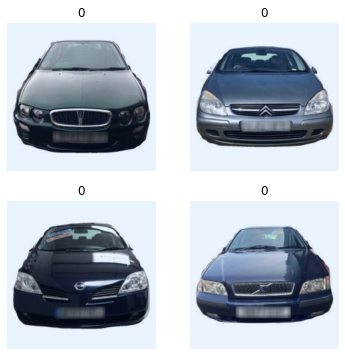

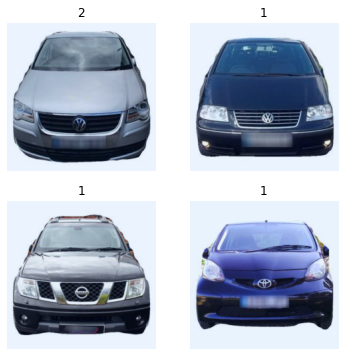

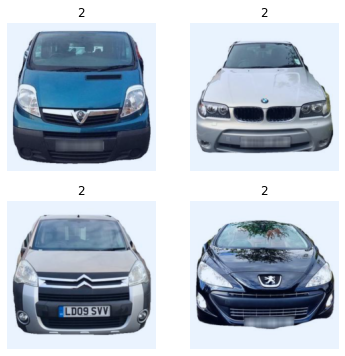

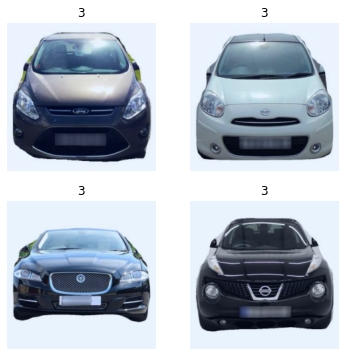

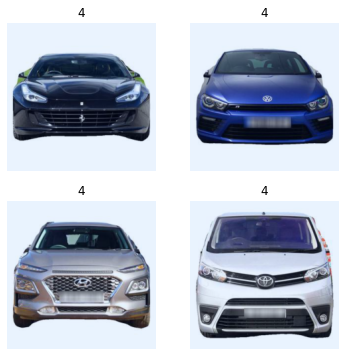

In [ ]:
plot_images(images0, pred_labels0)
plot_images(images1, pred_labels1)
plot_images(images2, pred_labels2)
plot_images(images3, pred_labels3)
plot_images(images4, pred_labels4)

#Automotive Design Typicality

### 1. Transer learning with Resnet18 pretrained model

In [ ]:
# Cancel all datas we dont need (we keep data only for Hatchback, SUV, MPV, Saloon, and convertible)

train_data = train_data.drop(train_data[train_data.bodytype == 'Estate'].index)
train_data = train_data.drop(train_data[train_data.bodytype == 'Coupe'].index)
train_data = train_data.drop(train_data[train_data.bodytype == 'Combi Van'].index)
train_data = train_data.drop(train_data[train_data.bodytype == 'Pickup'].index)
train_data = train_data.drop(train_data[train_data.bodytype == 'Limousine'].index)
train_data = train_data.drop(train_data[train_data.bodytype == 'Minibus'].index)
train_data = train_data.drop(train_data[train_data.bodytype == 'Panel Van'].index)
train_data=train_data.dropna(how='any')

test_data = test_data.drop(test_data[test_data.bodytype == 'Estate'].index)
test_data = test_data.drop(test_data[test_data.bodytype == 'Coupe'].index)
test_data = test_data.drop(test_data[test_data.bodytype == 'Combi Van'].index)
test_data = test_data.drop(test_data[test_data.bodytype == 'Pickup'].index)
test_data = test_data.drop(test_data[test_data.bodytype == 'Limousine'].index)
test_data = test_data.drop(test_data[test_data.bodytype == 'Minibus'].index)
test_data = test_data.drop(test_data[test_data.bodytype == 'Panel Van'].index)
test_data=test_data.dropna(how='any')

valid_data = valid_data.drop(valid_data[valid_data.bodytype == 'Estate'].index)
valid_data = valid_data.drop(valid_data[valid_data.bodytype == 'Coupe'].index)
valid_data = valid_data.drop(valid_data[valid_data.bodytype == 'Combi Van'].index)
valid_data = valid_data.drop(valid_data[valid_data.bodytype == 'Pickup'].index)
valid_data = valid_data.drop(valid_data[valid_data.bodytype == 'Limousine'].index)
valid_data = valid_data.drop(valid_data[valid_data.bodytype == 'Minibus'].index)
valid_data = valid_data.drop(valid_data[valid_data.bodytype == 'Panel Van'].index)
valid_data=valid_data.dropna(how='any')

In [ ]:
class DVMdataset_2(Dataset):
    def __init__(self, data, img_dir, transforms=True):
        df = data
        self.img_dir = img_dir
        self.brand = df['brand'].values
        self.model_year = df['model_year'].values
        self.model = df['model_name'].values
        self.bodytype = df['bodytype'].values  # add bodytype
        self.transform = transforms
    def __getitem__(self, index):
        dir_path = os.listdir(os.path.join(self.img_dir, self.img_dir, self.brand[index], str(self.model_year[index])))
        brand_name = self.brand[index]
        model_name = self.model[index]
        dico = [brand_name, model_name]
        separator = '$$'
        joindre = separator.join(dico)
        label = []
        for i in range(len(dir_path)):
          joindre2 = ''
          for y in range(len(joindre)):
            joindre2 = joindre2 + dir_path[i][y]
          if joindre2 == joindre:
            lien = os.path.join(self.img_dir, self.img_dir, self.brand[index], str(self.model_year[index]), dir_path[i])
            img = Image.open(os.path.join(self.img_dir, self.img_dir, self.brand[index], str(self.model_year[index]), dir_path[i]))
            if self.transform is not None:
              imga = self.transform(img)
              if self.bodytype[index] == 'Hatchback':
                label.append(0)
              elif self.bodytype[index] == 'SUV':
                label.append(1)
              elif self.bodytype[index] == 'MPV':
                label.append(2)
              elif self.bodytype[index] == 'Saloon':
                label.append(3)
              elif self.bodytype[index] == 'Convertible':
                label.append(4)
              else :
                print(self.bodytype[index])
                label.append(9)
              return imga, label[0]
    def __len__(self):
        return self.brand.shape[0]

In [ ]:
BATCH_SIZE = 88 # Keep the same than in first part of the assignment

train_dataset_2 = DVMdataset_2(data=train_data,img_dir='confirmed_fronts/',transforms=train_transforms)
train_loader_2 = DataLoader(dataset=train_dataset_2,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True)


valid_dataset_2 = DVMdataset_2(data=valid_data,img_dir='confirmed_fronts/',transforms=test_transforms)
valid_loader_2 = DataLoader(dataset=valid_dataset_2,
                          batch_size=BATCH_SIZE,
                          shuffle=False)


test_dataset_2 = DVMdataset_2(data=test_data,img_dir='confirmed_fronts/',transforms=test_transforms)
test_loader_2 = DataLoader(dataset=test_dataset_2,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [ ]:
best_valid_loss = float('inf')

learning_rate = 0.00067 # Keep the same than in first part of the assignment
optimizer = optim.Adam(pretrained_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model_2 = pretrained_model.to(device)
criterion = criterion.to(device)

EPOCHS = 8
for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model_2, train_loader_2, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model_2, valid_loader_2, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_2.state_dict(), 'as3-model_2.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 6m 36s
	Train Loss: 2.049 | Train Acc: 41.48%
	 Val. Loss: 0.985 |  Val. Acc: 58.75%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 6m 31s
	Train Loss: 0.852 | Train Acc: 66.14%
	 Val. Loss: 1.004 |  Val. Acc: 55.00%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 6m 32s
	Train Loss: 0.540 | Train Acc: 79.43%
	 Val. Loss: 0.422 |  Val. Acc: 84.49%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 6m 32s
	Train Loss: 0.276 | Train Acc: 90.68%
	 Val. Loss: 0.316 |  Val. Acc: 89.20%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 6m 31s
	Train Loss: 0.160 | Train Acc: 95.00%
	 Val. Loss: 0.180 |  Val. Acc: 95.17%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 6m 32s
	Train Loss: 0.124 | Train Acc: 96.65%
	 Val. Loss: 0.505 |  Val. Acc: 78.81%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 6m 31s
	Train Loss: 0.089 | Train Acc: 97.78%
	 Val. Loss: 0.087 |  Val. Acc: 97.73%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 6m 32s
	Train Loss: 0.062 | Train Acc: 98.58%
	 Val. Loss: 0.064 |  Val. Acc: 98.58%


In [ ]:
model_2.load_state_dict(torch.load('as3-model_2.pt'))

test_loss, test_acc = evaluate(model_2, test_loader_2, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Test Loss: 0.077 | Test Acc: 96.95%


### 2. Extract the features output of the last avgpool layer


In [ ]:
model_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# To get the output of avgpool layer, we can drop the last layer in the model_2

model_2_2 = nn.Sequential(*list(model_2.children())[:-1])